Calculating AUC just for single task ID.<br> Therefore, not making a scalable solution for POC.

In [2]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
filepath = "../data/student_vectors_n_task_10_n_limit_100000.json"
student_vectors = json.load(open(filepath))

In [23]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 11659


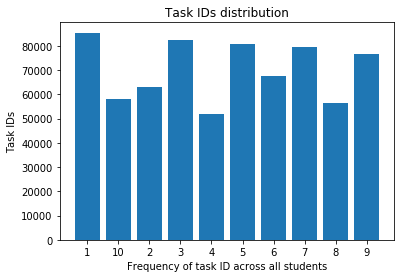

Task IDs mapping: 
Task ID -> 1zsCldT4p8.set1(1) is attempted 85462 times.
Task ID -> kvig7fcCVc.partb(2) is attempted 62936 times.
Task ID -> p7cfRPp-kQ.partb(3) is attempted 82476 times.
Task ID -> dTZlXODVzW.partb(4) is attempted 51770 times.
Task ID -> 1zsCldT4p8.set2(5) is attempted 80932 times.
Task ID -> UlJYoQjOUR.partb(6) is attempted 67448 times.
Task ID -> 9wRCzK1G7F.partb(7) is attempted 79468 times.
Task ID -> 2yCqg9SbT0.set1(8) is attempted 56603 times.
Task ID -> DebcfZEEmI.proper_fractions(9) is attempted 76611 times.
Task ID -> nl-M69Ez9k.parta(10) is attempted 58176 times.


In [24]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
position_2 = 1
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in another_2:
            another_2[j['task_id']] = str(position_2)
            position_2 = position_2 + 1
        cnt2[another_2[j['task_id']]] += 1
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times.")

In [56]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    #make sequences
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.])
                else:
                    interactions.append([0.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)
            
    #do the padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),1])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]

    num_units = 5
    len_vector = 1
    l_rate = 0.1
    epochs = 20
    display_ep = 10
    
    for r in range(10):
        print("\n\n"+ str(r+1) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(5)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid )
            #outputs = tf.nn.sigmoid(outputs)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        #optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc,  opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            for epoch in range(1, epochs+1):
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc,opts], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc,opts], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Step: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) +":"+str(trainAUC) + ", test set AUC: "+ str(testOPTS)+":"+str(testAUC) +";")
            prediction = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
            view_point = len(test_x) - 1 #np.argsort(test_seqlen)[15]
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0][view_point][:test_seqlen[view_point]])
            train_AUC_taski.append(trainOPTS)
            test_AUC_taski.append(testOPTS)
    test_AUC_all_tasks[i] = [np.mean(test_AUC_taski),np.std(test_AUC_taski)]
    train_AUC_all_tasks[i] = [np.mean(train_AUC_taski),np.std(train_AUC_taski)]




Calculating for Task ID: 1zsCldT4p8.set1 which has the frequency: 85462



1 Time Run.
Step: 1, cost: 0.95818996, train set AUC: 0.90400493:0.0, test set AUC: 0.9047591:0.90400493;
Step: 10, cost: 0.8784567, train set AUC: 0.69651604:0.9047591, test set AUC: 0.69888836:0.69651604;
Step: 20, cost: 0.7771806, train set AUC: 0.6298295:0.69888836, test set AUC: 0.6330037:0.6298295;


true:

[[0.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.16791715]
 [0.17751442]
 [0.18097486]
 [0.18174297]]


2 Time Run.
Step: 1, cost: 0.9581469, train set AUC: 0.970827:0.0, test set AUC: 0.9700258:0.970827;
Step: 10, cost: 0.8783703, train set AUC: 0.73247135:0.9700258, test set AUC: 0.734933:0.73247135;
Step: 20, cost: 0.77713174, train set AUC: 0.653794:0.734933, test set AUC: 0.65657604:0.653794;


true:

[[0.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.16746488]
 [0.1764606 ]
 [0.18377393]
 [0.18927309]]


3 Time Run.
Step: 1, cost: 0.95829725, train set AUC: 0.29303357:0.0, test set AUC: 0.27829486:0.29303357

Step: 10, cost: 0.85013336, train set AUC: 0.5868556:0.60440326, test set AUC: 0.5993739:0.5868556;
Step: 20, cost: 0.77250695, train set AUC: 0.58618253:0.5993739, test set AUC: 0.59764117:0.58618253;


true:

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.21252915]
 [0.21622324]
 [0.22742938]
 [0.24057674]
 [0.2435502 ]
 [0.2577541 ]
 [0.2649824 ]
 [0.27194333]
 [0.2780005 ]
 [0.28302726]
 [0.2870903 ]]


9 Time Run.
Step: 1, cost: 0.9086952, train set AUC: 0.1455336:0.0, test set AUC: 0.13999447:0.1455336;
Step: 10, cost: 0.85143137, train set AUC: 0.34944052:0.13999447, test set AUC: 0.36236364:0.34944052;
Step: 20, cost: 0.7742904, train set AUC: 0.45272085:0.36236364, test set AUC: 0.47361875:0.45272085;


true:

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.20990038]
 [0.2021423 ]
 [0.20376058]
 [0.2083327 ]
 [0.21984664]
 [0.2178933 ]
 [0.21910128]
 [0.22107701]
 [0.22296318]
 [0.2245829 ]
 [0.22589892

Step: 1, cost: 0.95283675, train set AUC: 0.50085455:0.0, test set AUC: 0.49330607:0.50085455;
Step: 10, cost: 0.87273234, train set AUC: 0.49644366:0.49330607, test set AUC: 0.4970265:0.49644366;
Step: 20, cost: 0.7753243, train set AUC: 0.5216294:0.4970265, test set AUC: 0.531685:0.5216294;


true:

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.17056747]
 [0.16843955]
 [0.169328  ]
 [0.17112562]
 [0.17299812]
 [0.17468764]
 [0.17569032]
 [0.17626907]
 [0.17665057]
 [0.17741357]
 [0.1782306 ]
 [0.17901547]
 [0.1797289 ]
 [0.18035644]
 [0.17975922]
 [0.18023442]
 [0.17980838]
 [0.18000913]
 [0.18034448]
 [0.18073069]
 [0.18111487]
 [0.18147127]
 [0.18178873]
 [0.18206416]
 [0.1822989 ]]


10 Time Run.
Step: 1, cost: 0.95299816, train set AUC: 0.025104417:0.0, test set AUC: 0.025836851:0.025104417;
Step: 10, cost: 0.8729038, train set AUC: 0.25836164:0.025836851, te

Step: 20, cost: 0.77675104, train set AUC: 0.6595877:0.7413243, test set AUC: 0.66091657:0.6595877;


true:

[[1.]
 [0.]
 [1.]
 [1.]]


prediction

[[0.19006205]
 [0.18556835]
 [0.1998366 ]
 [0.20932807]]


7 Time Run.
Step: 1, cost: 0.9578702, train set AUC: 0.9834771:0.0, test set AUC: 0.98317266:0.9834771;
Step: 10, cost: 0.8781211, train set AUC: 0.7252288:0.98317266, test set AUC: 0.7212991:0.7252288;
Step: 20, cost: 0.77683043, train set AUC: 0.64195246:0.7212991, test set AUC: 0.6417119:0.64195246;


true:

[[1.]
 [0.]
 [1.]
 [1.]]


prediction

[[0.16978905]
 [0.18099585]
 [0.18044241]
 [0.188552  ]]


8 Time Run.
Step: 1, cost: 0.9583244, train set AUC: 0.016661936:0.0, test set AUC: 0.01694331:0.016661936;
Step: 10, cost: 0.8786241, train set AUC: 0.22971828:0.01694331, test set AUC: 0.23520787:0.22971828;
Step: 20, cost: 0.7773823, train set AUC: 0.32291117:0.23520787, test set AUC: 0.32863033:0.32291117;


true:

[[1.]
 [0.]
 [1.]
 [1.]]


prediction

[[0.15223187]
 [0.1496

Step: 20, cost: 0.7769055, train set AUC: 0.65934455:0.7363404, test set AUC: 0.65749073:0.65934455;


true:

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.1803459 ]
 [0.19182223]
 [0.18475728]
 [0.19725658]
 [0.20518817]
 [0.21157196]
 [0.21659806]]


3 Time Run.
Step: 1, cost: 0.95854825, train set AUC: 0.9726482:0.0, test set AUC: 0.97262615:0.9726482;
Step: 10, cost: 0.87746036, train set AUC: 0.73953056:0.97262615, test set AUC: 0.7363112:0.73953056;
Step: 20, cost: 0.77690214, train set AUC: 0.65937704:0.7363112, test set AUC: 0.6575347:0.65937704;


true:

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.17676957]
 [0.18903694]
 [0.19220094]
 [0.20148978]
 [0.21189146]
 [0.22119562]
 [0.2291188 ]]


4 Time Run.
Step: 1, cost: 0.9584768, train set AUC: 0.9711712:0.0, test set AUC: 0.9711961:0.9711712;
Step: 10, cost: 0.8774212, train set AUC: 0.73847383:0.9711961, test set AUC: 0.73518986:0.73847383;
Step: 20, cost: 0.7768872, train set AUC: 0.65849435:



1 Time Run.
Step: 1, cost: 0.954588, train set AUC: 0.96231365:0.0, test set AUC: 0.96214116:0.96231365;
Step: 10, cost: 0.87343335, train set AUC: 0.7326257:0.96214116, test set AUC: 0.7310428:0.7326257;
Step: 20, cost: 0.7757121, train set AUC: 0.65459454:0.7310428, test set AUC: 0.6540692:0.65459454;


true:

[[1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.17960128]
 [0.18640447]
 [0.19151919]
 [0.19580854]]


2 Time Run.
Step: 1, cost: 0.95459986, train set AUC: 0.95664936:0.0, test set AUC: 0.9567264:0.95664936;
Step: 10, cost: 0.87349296, train set AUC: 0.7296173:0.9567264, test set AUC: 0.72806025:0.7296173;
Step: 20, cost: 0.7757625, train set AUC: 0.6525872:0.72806025, test set AUC: 0.6521085:0.6525872;


true:

[[1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.17605343]
 [0.1802    ]
 [0.1829156 ]
 [0.18466483]]


3 Time Run.
Step: 1, cost: 0.9546033, train set AUC: 0.9466613:0.0, test set AUC: 0.94694924:0.9466613;
Step: 10, cost: 0.87351984, train set AUC: 0.7201855:0.94694924, test 

In [ ]:
pp.pprint(test_AUC_all_tasks)


In [ ]:
pp.pprint(train_AUC_all_tasks)